In [43]:
# tabular data
import numpy as np
import pandas as pd
#scipy for stats
from scipy import stats
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn for modeling:
from sklearn.tree import DecisionTreeClassifier,\
export_text, \
plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, \
classification_report, \
confusion_matrix
from sklearn.model_selection import train_test_split
#env,acquire,prep,
import env
import acquire
import prepare
import explore
#ignore all warnings, it's all good, trust me
import warnings
warnings.simplefilter(action='ignore')

# Goal
- Identify what causes cx churn for Telco
- Use those features to build a model to determine if a customer is likely to churn
- Churn is defined as a customer who has left Telco
- This information can be useful to help Telco find ways to retain customers who are likely to churn.

# Project Description
- Aquire data
- Prep data
- Explore data to find correlations and investigate significance
- Build multiple ml models to predict churn
- Test and impliment the best one
- Give recommendations based on findings

## Acquire data
- orginally from codeup mysql then cached to local folder
- orginally 7043 rows 24 cols
- rows are individual cx
- columns represent cx features

In [134]:
#give the data a home
telco = acquire.get_telco_data()

## Prep data
- check for duplicates
- remove 'id's for catagorical features
- check for nulls
- converted total charges to float
- removed 11 cx with null total charges
- encoded churn, removed string version
- encoded categorical variables
- split that data up


In [135]:
#clean the data
telco = prepare.clean_telco(telco)

In [136]:
#lets look at the data
telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,churn_encoded
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.30,One year,DSL,Mailed check,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.40,Month-to-month,DSL,Mailed check,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Month-to-month,Fiber optic,Electronic check,1
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Month-to-month,Fiber optic,Electronic check,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.40,Month-to-month,Fiber optic,Mailed check,1


In [137]:
#get dummies
telco = prepare.dem_dummies(telco)

In [138]:
#split the data
train, validate, test = prepare.train_validate_test_split(telco, "churn_encoded")

In [139]:
train.shape, validate.shape, test.shape

((4572, 31), (1405, 31), (1055, 31))

## DATA DICTIONARY

In [7]:
#data dictionary
print(prepare.generate_data_dictionary(telco))

Enter description for gender:  male or female
Enter description for senior_citizen:  binary for cx over 65
Enter description for partner:  y or n if cx has partner
Enter description for dependents:  y or n if cx has dependents
Enter description for tenure:  months cx has stayed with co
Enter description for phone_service:  y or n if cx has phone service
Enter description for multiple_lines:  y n or no phone service
Enter description for online_security:  y n or no internet 
Enter description for online_backup:  y n or no internet
Enter description for device_protection:  y n or no internet
Enter description for tech_support:  y n or no internet
Enter description for streaming_tv:  y n or no internet
Enter description for streaming_movies:  y n or no internet
Enter description for paperless_billing:  y or n for paperless billing
Enter description for monthly_charges:  amount cx charged monthly
Enter description for total_charges:  total amount cx charged
Enter description for contract_t

              Column Name Data Type              Column Description
0                  gender    object                  male or female
1          senior_citizen     int64           binary for cx over 65
2                 partner    object        y or n if cx has partner
3              dependents    object     y or n if cx has dependents
4                  tenure     int64    months cx has stayed with co
5           phone_service    object  y or n if cx has phone service
6          multiple_lines    object         y n or no phone service
7         online_security    object             y n or no internet 
8           online_backup    object              y n or no internet
9       device_protection    object              y n or no internet
10           tech_support    object              y n or no internet
11           streaming_tv    object              y n or no internet
12       streaming_movies    object              y n or no internet
13      paperless_billing    object    y or n fo

# Lets explore this thing!

### lets start by looking at our churning cx, what percentage of cx are churning?

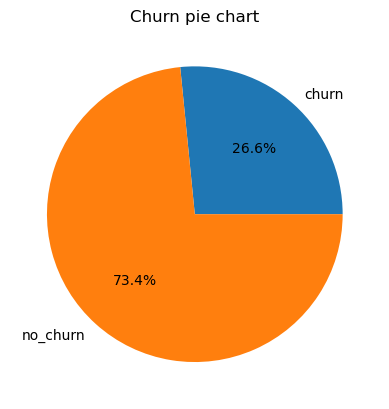

In [21]:
sizes = [len(train[train.churn_encoded == 1]),len(train[train.churn_encoded == 0])]
labels = 'churn', 'no_churn'
fig, ax = plt.subplots()        
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Churn pie chart')
plt.show()

# well good news is most cx are still with the company, we must be doing something right!

## Does Gender play a factor in Churn?


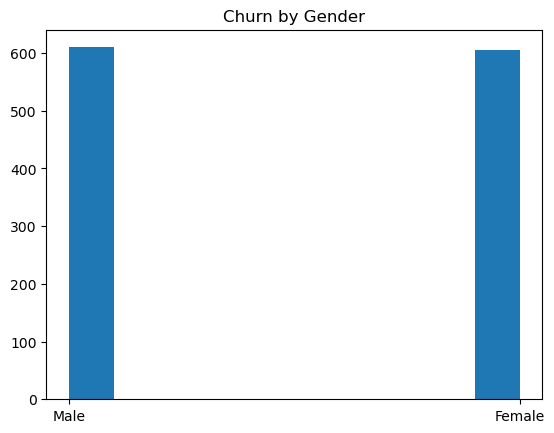

In [11]:
plt.hist(train.gender[train.churn_encoded == 1])
plt.title('Churn by Gender')
plt.show()

## From the visualization, it doesn't look like it but lets run a chi^2 test and confirm

- H$_0$: Gender does not play a factor in churn
- H$_a$: Gender does influence churn

In [12]:
observed = pd.crosstab(train.gender, train.churn_encoded)
α=0.05
chi2, p, _, expected = stats.chi2_contingency(observed)
if p < α:
    print('we can reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we fail to reject the null hypothesis


# well.. that proves it, gender does not influence churn

## what about age? does being a senior citizen influnce churn?

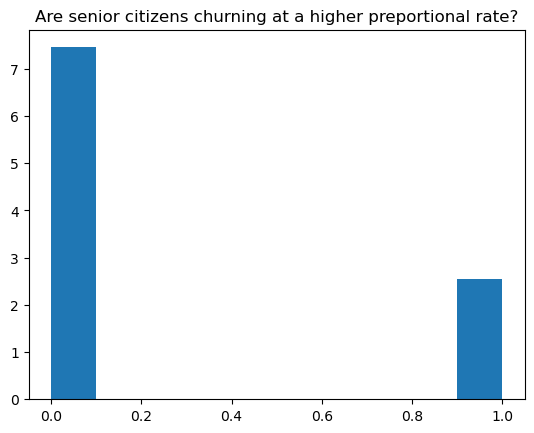

In [178]:
plt.hist(telco.senior_citizen[telco.churn_encoded == 1],density=True)
plt.title('Are senior citizens churning at a higher preportional rate?')
plt.show()

this chart is normalized to represent total training set population so from this chart we speculate that cx under 65 do churn at a greater rate

## lets run a chi^2 to check our if our speculation is significant
- H$_0$: age does not play a factor in churn
- H$_a$: age does influence churn

In [174]:
observed = pd.crosstab(telco.senior_citizen, telco.churn_encoded)
α=0.05
chi2, p, _, expected = stats.chi2_contingency(observed)
if p < α:
    print('we can reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we can reject the null hypothesis


## the hypothisis is valid, age does influence churn, but this is likely due the fact that most people are under age 65

# lets have a look at account information. Do contract type, paperless billing, payment type have an effect on churn?

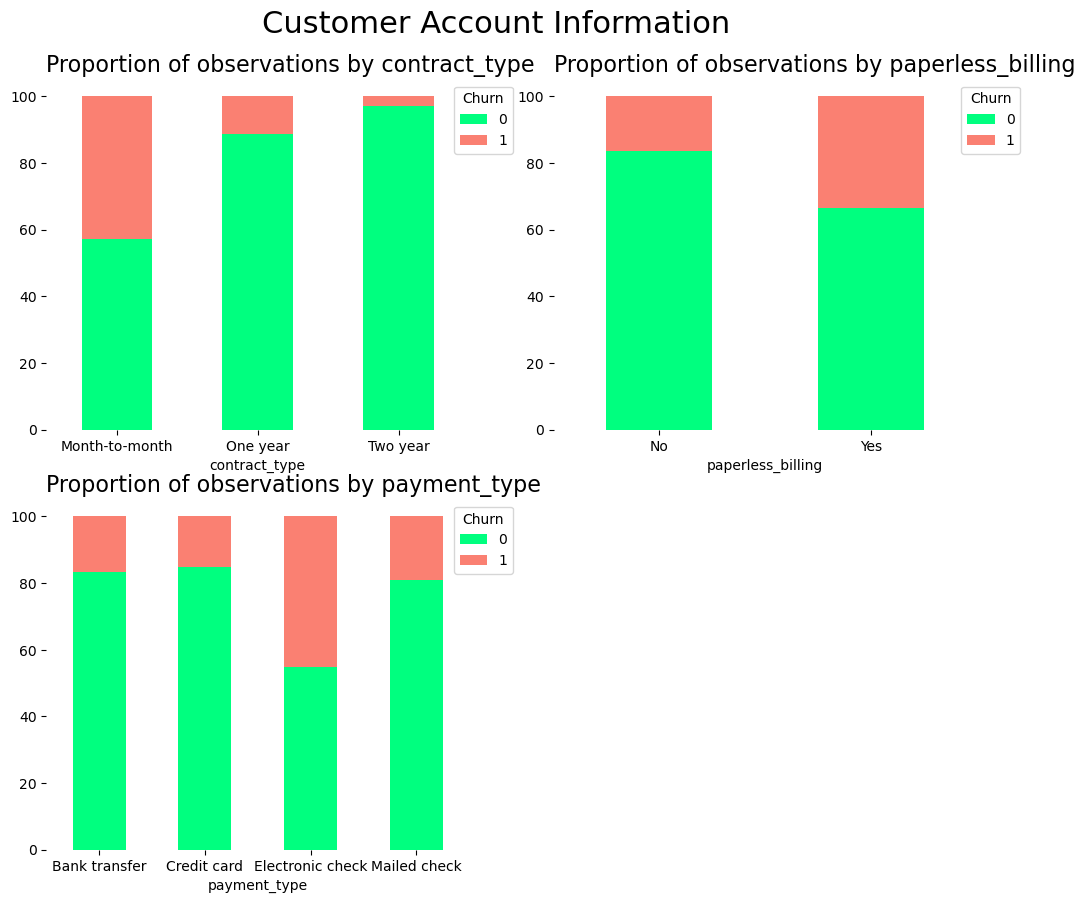

In [4]:
# customer account column names
account_columns = ['contract_type', 'paperless_billing', 'payment_type']

# stacked plot of customer account columns
explore.percentage_stacked_plot(account_columns, 'Customer Account Information')

# here we can see
- Cx with month-to-month contracts have higher churn rates compared to clients with yearly contracts.
- Cx who opted for an electronic check as paying method are more likely to leave the company.
- Cx subscribed to paperless billing churn more than those who are not subscribed.

# Exploration sumarry:
- 73.2 % of cx are still with the company!
- Gender does not effect churn
- Age does but this likely due to the majority of cx being under 65
- cx with month to month contracts churn at higher rates, likely due to the ease of cancelation
- cx paying by electronic check churn at higher rates
- cx with with paperless billing churn more, this is likely due to most cx using paperless billing

# lets get into modeling!

since we know around 73% of cx haven't churned, our baseline prediction is 0(not churned)

In [140]:
#sepate our features from our target
X_cols = train.columns.to_list()
X_cols.remove('churn_encoded')
y_col = 'churn_encoded'
#save them to a more useable format
X_train = train[X_cols]
y_train = train[y_col]


In [142]:
#establish a new column for baseline prediction = 0
train['baseline_pred'] = 0
#lets establish our baseline accuracy
baseline_accuracy = (train.churn_encoded == 0).mean()

In [143]:
#we can confirm our baseline accuracy around 73%
print(f'{baseline_accuracy:.2%}')

73.43%


# lets build our first model using a decision tree
- we'll use a max depth of 2

In [144]:
#make the thing
dt1 = DecisionTreeClassifier(max_depth=2)
#fit the thing
dt1.fit(X_train, y_train)
#use the thing
model_1_preds = dt1.predict(X_train)

In [145]:
#add model 1 predictions to train
train['dtmodel1_pred'] = model_1_preds

# lets build our second model using a decision tree
- this time we won't set a max depth

In [146]:
#make the thing
dt2 = DecisionTreeClassifier()
#fit the thing
dt2.fit(X_train, y_train)
#use the thing
model_2_preds = dt1.predict(X_train)

In [147]:
#add model 1 predictions to train
train['dtmodel2_pred'] = model_2_preds

# lets build a third model using a random forest

In [148]:
#make the thing
rf1 = RandomForestClassifier()
#fit the thing
rf1.fit(X_train, y_train)
#use the thing
model_3_preds = rf1.predict(X_train)

In [149]:
#add model 2 predictions to train
train['rfmodel3_pred'] = model_3_preds

# lets make a df and csv for our predictions

In [150]:
#add to predictions df and csv
#predictions_df = train[['churn_encoded', 'baseline_pred','dtmodel1_pred','rfmodel3_pred']]
# save the DataFrame to a CSV file
#predictions_df.to_csv('predictions.csv', index=False)

# lets get our stats from our training sets

In [151]:
print(f'Our baseline accuracy is : {baseline_accuracy:.2%}')
print(f'''
Performance in accuracy of model1, a DT with max depth of 2, on training data:
Accuracy: {dt1.score(X_train, y_train):.2%}''')
print(f'''
Performance in accuracy of model2, a DT with no set max depth, on training data:
Accuracy: {dt2.score(X_train, y_train):.2%}''')
print(f'''
Performance in accuracy of model3, an RF with no set max depth, on training data:
Accuracy: {rf1.score(X_train, y_train):.2%}''')

Our baseline accuracy is : 73.43%

Performance in accuracy of model1, a DT with max depth of 2, on training data:
Accuracy: 79.18%

Performance in accuracy of model2, a DT with no set max depth, on training data:
Accuracy: 99.91%

Performance in accuracy of model3, an RF with no set max depth, on training data:
Accuracy: 99.91%


# we can see that all of our models have out performed the baseline, lets run it on our validation set to check for overfiting

In [166]:
#start by setting up our variables
X_val = validate[X_cols]
y_val = validate[y_col]


In [169]:
print(f'''
Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): {dt1.score(X_train, y_train):.2%}
Accuracy (validate): {dt1.score(X_val, y_val):.2%}''')
print(f'''
Performance in accuracy of Decision Tree 2 on training data:
Accuracy (train): {dt2.score(X_train, y_train):.2%}
Accuracy (validate): {dt2.score(X_val, y_val):.2%}''')
print(f'''
Performance in accuracy of random forest on training data:
Accuracy (train): {rf1.score(X_train, y_train):.2%}
Accuracy (validate): {rf1.score(X_val, y_val):.2%}''')


Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): 79.18%
Accuracy (validate): 79.57%

Performance in accuracy of Decision Tree 2 on training data:
Accuracy (train): 99.91%
Accuracy (validate): 71.96%

Performance in accuracy of random forest on training data:
Accuracy (train): 99.91%
Accuracy (validate): 80.00%


# we can see that model 1, the decision tree with a max depth of 2, performed the best, having the lowest difference in accuracy between the training and validation.

# Here we can see the steps taken by the decision tree

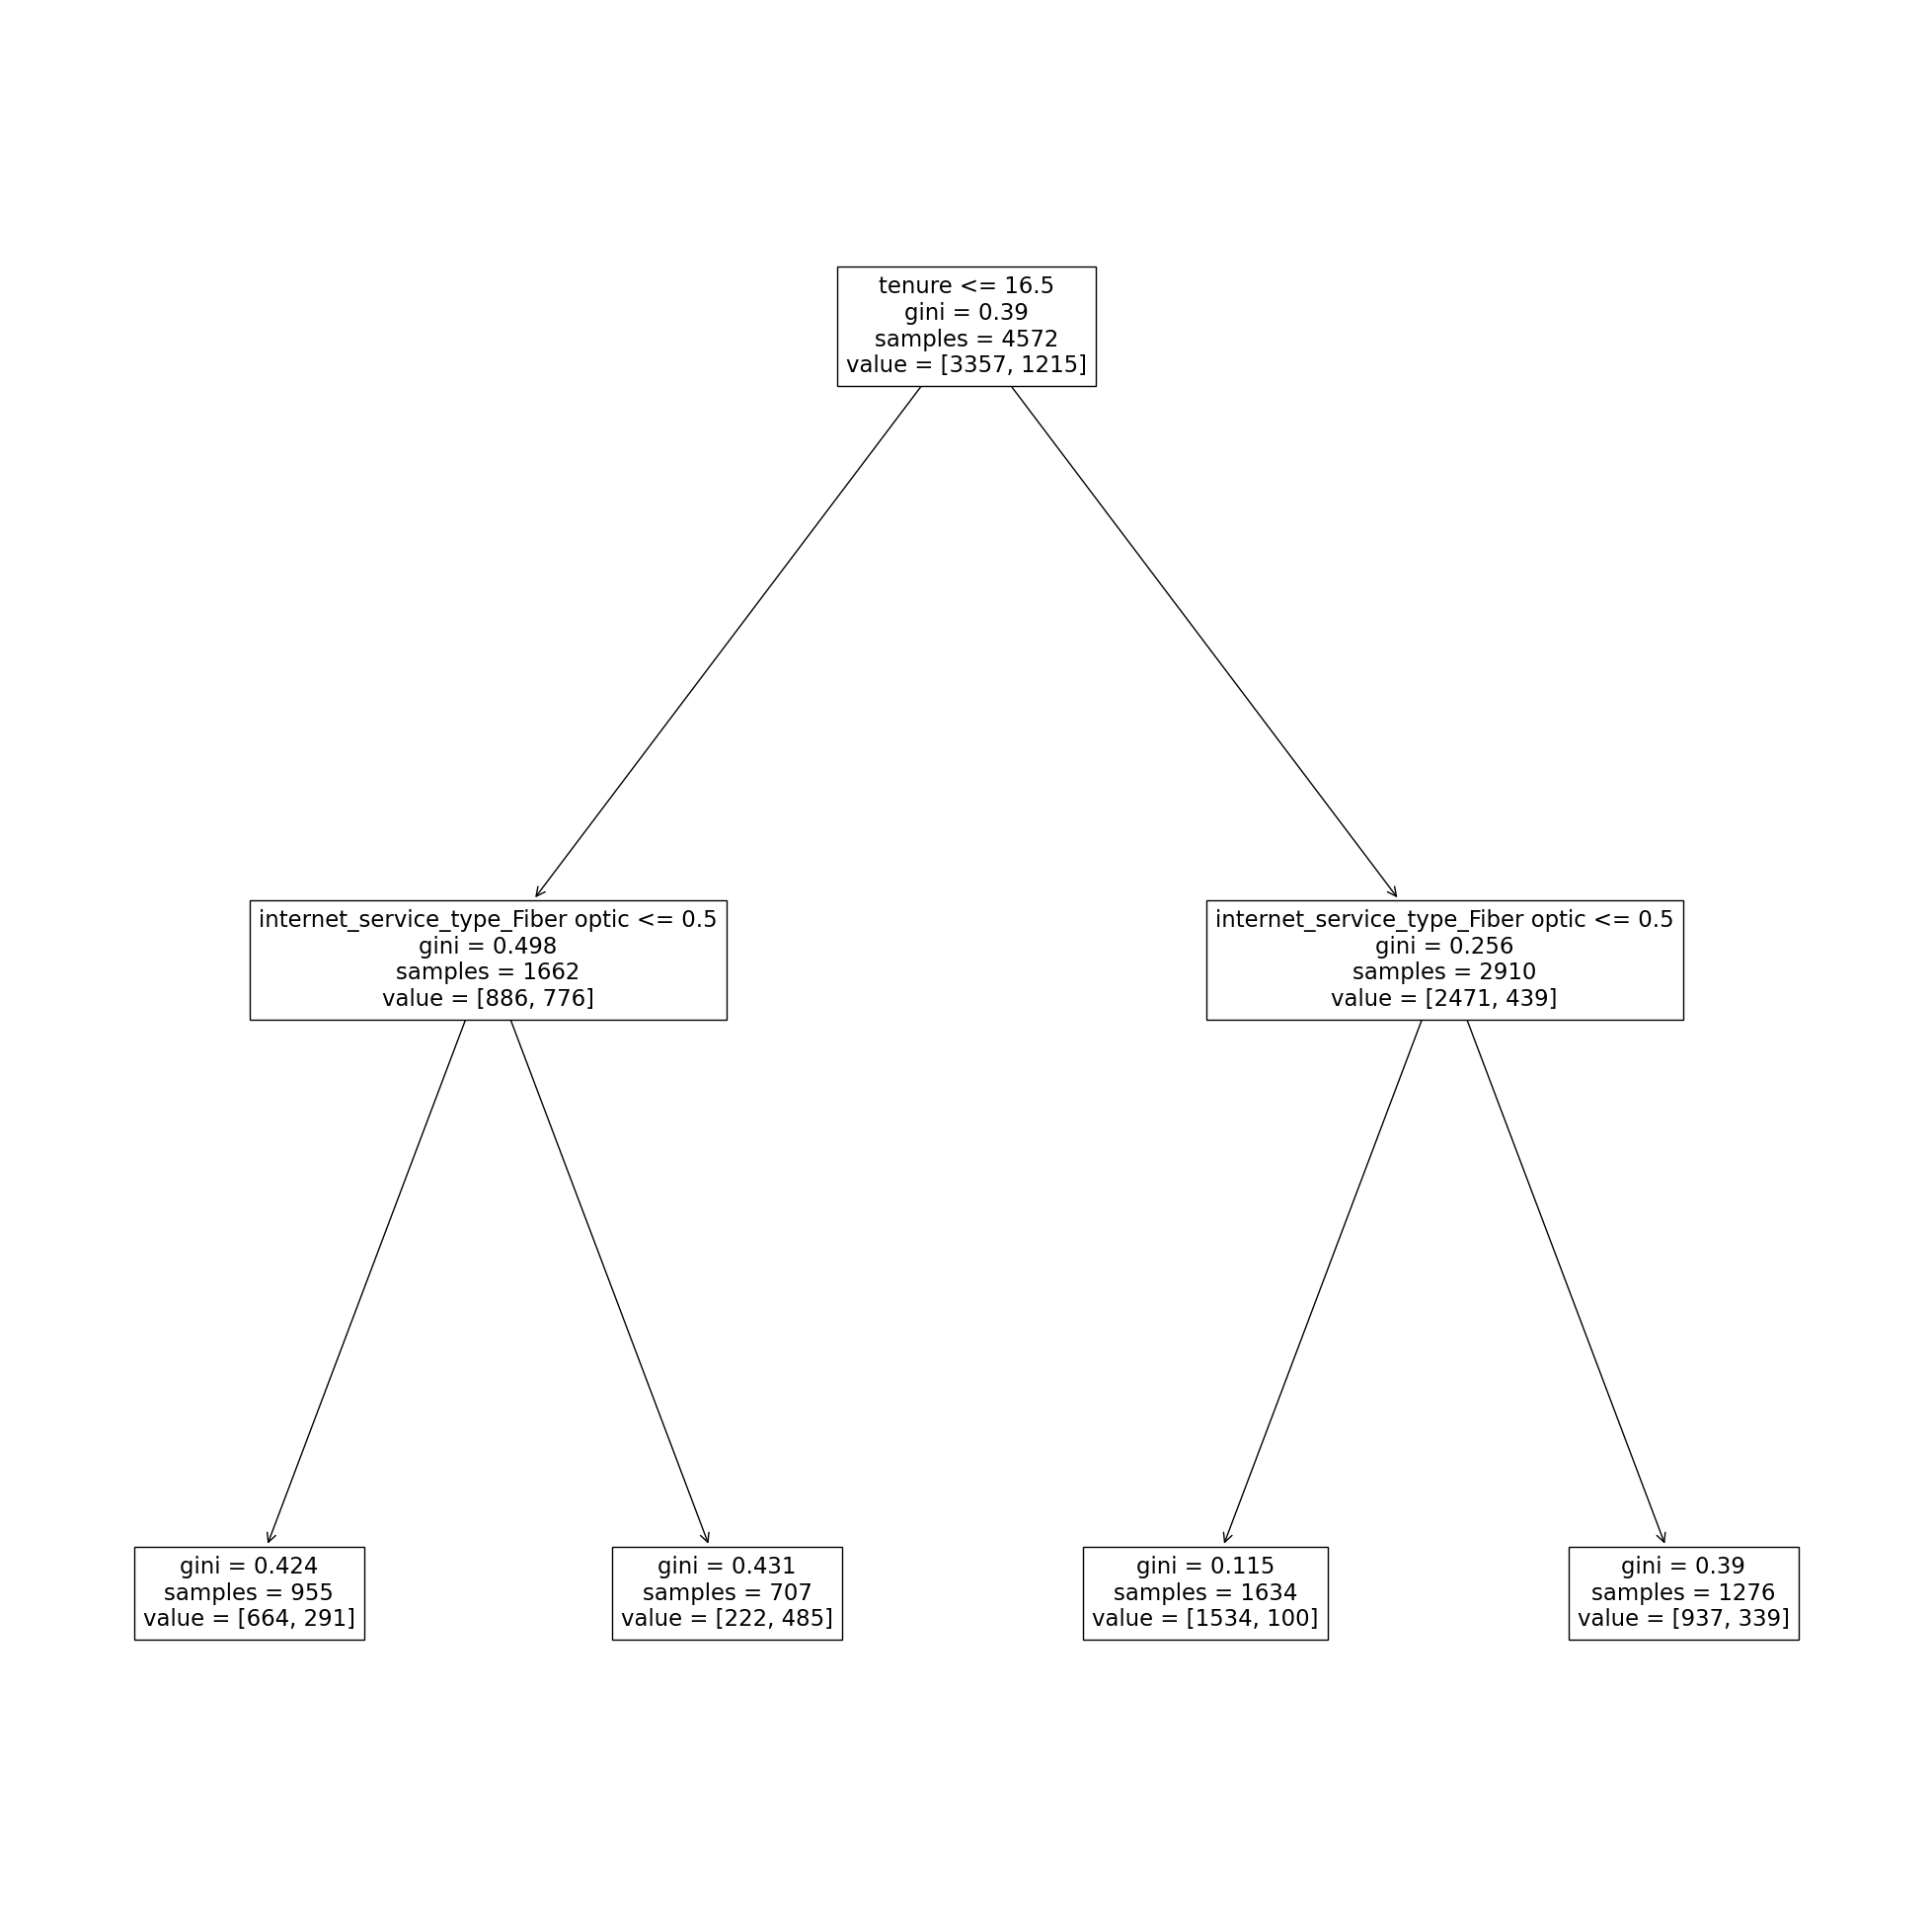

In [170]:
plt.figure(figsize=(25,25))
plot_tree(dt1,feature_names=X_cols)
plt.show()

Here we can see churning indicators found by the model as cx that have 16.5 months or less tenure and do not have fiber optic internet.

# We'll be taking model 1 into testing to finally determine if we can better predict churn

In [172]:
# this shows our accuracy on the test data set
dt1.score(test[X_cols], test[y_col])

0.7744075829383886

## WOW 77.44%! We've beat the baseline churn estimation of 73.43 by 4.01%

# Modeling Summary
- Using the 1st model we can out perform our current churn estimations by 4.01%, and account for extra revenue of $114,803.39
- The model found cx with under 16.5 months of tenure and without fiber optic internet are the most likely to churn.

# Conclusion
- 73.4% of cx are still with the company!
- Gender does not effect churn
- Age does but this likely due to the majority of cx being under 65, a scaling issue
- cx with month to month contracts churn at higher rates, likely due to the ease of cancelation
- cx paying by electronic check churn at higher rates
- cx with with paperless billing churn more, this is likely due to most cx using paperless billing, a scaling issue
- Using the 1st model we can out perform our current churn estimations by 4.01%, and account for extra revenue of $114,803.39
- The model found cx with under 16.5 months of tenure and without fiber optic internet are the most likely to churn.

# Recommendations
- migrate cx with month to month contracts to yearly
- phase out electronic check payments in favor of credit card by offer a slim discount
- implement model 1 to predict churn and better leverage the expected revenue into retention discounts
- when cx reach 15 months offer a discount to encourage retention
- expand fiber optic service area to capture more cx and improve retention
- provide location data to influence fiber optic expansion planning

# Room for improvement
- focus more on continuous variables like monthly charges
- fix scaling issues
- find and investigate more correlations
- preform more statistical testing to drive correlation testing
- clear code cells from presentable notebook
- run iterative decision tree model building to improve accuracy
- test subsets with hand picked variables